<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller: Reconocimiento facial con K-medias y K-medoides

En este caso-taller vamos a aplicar K-medias y K-medoides para agrupar rostros de indiviudos. Utilizaremos la base de datos conocida como Caras Olivetti. Esta base contiene diez imágenes diferentes de  40 personas distintas. Para algunas personas, las imágenes se tomaron en diferentes momentos, variando la iluminación, las expresiones faciales (ojos abiertos/cerrados, sonriendo/sin sonreír) y los detalles faciales (gafas/sin gafas). Todas las imágenes fueron tomadas contra un fondo homogéneo oscuro con los sujetos en una posición frontal erguida (con tolerancia a algún movimiento lateral). Esta base viene incluida dentro de la libraría `scikit-learn` y fueron provistas por T&T Laboratories Cambridge para que la comunidad académica la utilice para la evaluación de modelos predictivos.

## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos

Los datos pueden ser bajados directamente utilizando la librería `scikit-learn`,  la función que le permite hacer esto es `fetch_olivetti_faces`.

In [1]:
!pip install scikit-learn-extra

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import svd #pueden explorar con sklearn
from sklearn.decomposition import TruncatedSVD

import os
os.environ["OMP_NUM_THREADS"] = '2'


from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix
from sklearn.decomposition import PCA
import itertools
from sklearn_extra.cluster import KMedoids

In [3]:
# Utilice este espacio para escribir el código.
from sklearn.datasets import fetch_olivetti_faces

olivetti_faces = fetch_olivetti_faces(data_home="data")

Comenzamos instalando e importando las librerías que vamos a utilizar en el desarrollo del taller. Luego descargamos la base de datos utilizando la librería scikit learn y la alojamos en la carpeta "data".

### 2.  Análisis preliminar

#### 2.1. Describa los contenidos de la base de datos, tenga en cuenta que debe detallar los elementos, la dimensión de la base, y la dimensión de las imágenes.

In [4]:
print(olivetti_faces.DESCR)

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and 
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position 
    (with tolerance for some side movement).

**Data Set Characteristics:**

    =================   =====================
    Classes    

In [5]:
print("Tipo de objeto descargado:" , type(olivetti_faces))

for key, value in olivetti_faces.items():
    print(f"Clave: {key}")
    print(f"Tipo de valor: {type(value)}")
    if isinstance(value, str):
        # Imprimir el valor directamente si es una cadena de texto
        print(f"Valor: {value[:10]}...")  # Mostrar solo los primeros 100 caracteres si es largo
    elif isinstance(value, (list, np.ndarray)):
        # Si es un array de NumPy o una lista, mostrar la forma o longitud
        print(f"Forma/Longitud: {value.shape if isinstance(value, np.ndarray) else len(value)}")
    else:
        # Mostrar el valor directamente si es de otro tipo
        print(f"Valor: {value}")
    print("-" * 40)  # Separador para claridad

Tipo de objeto descargado: <class 'sklearn.utils._bunch.Bunch'>
Clave: data
Tipo de valor: <class 'numpy.ndarray'>
Forma/Longitud: (400, 4096)
----------------------------------------
Clave: images
Tipo de valor: <class 'numpy.ndarray'>
Forma/Longitud: (400, 64, 64)
----------------------------------------
Clave: target
Tipo de valor: <class 'numpy.ndarray'>
Forma/Longitud: (400,)
----------------------------------------
Clave: DESCR
Tipo de valor: <class 'str'>
Valor: .. _olivet...
----------------------------------------


La informacion esta almacenada en un objeto de tipo "utils bunch" que es similar a un diccionario y se compone de varios numpy arrays y un string:

- **data**: tiene la forma de n x f en donde:
    - **n** es la cantidad total de imagenes obtenidas por la carga de informacion
    - **f** es la imagen correspondiente al dato $n_i$ reformada de tal manera que queda como un vector 1 x k , donde k es igual a la multiplicacion de (h*w) donde h es la altura de la imagen y w es el ancho de la misma (ambas medidas en pixeles), k tambien se interpreta como el numero total de pixeles en la imagen

- **images**: tiene almacenados los datos en la forma n x 1, sin embargo este primer elemento es una matriz de la forma (h x w)

- **target**: array de tamaño n x 1 que contiene la codificacion numerica que indica de quien es la cara, tiene valores desde 0 hasta 39

In [6]:
(n,k) = olivetti_faces["data"].shape
print("Data:")
print("cantidad de líneas/imágenes: {n}".format(n=n))
print("cantidad de columnas (total de pixeles en la imagen): {k}".format(k=k))

Data:
cantidad de líneas/imágenes: 400
cantidad de columnas (total de pixeles en la imagen): 4096


In [7]:
(n,h,w) = olivetti_faces["images"].shape
print("Images:")
print("cantidad de líneas/imágenes: {n}".format(n=n))
print("altura de la imagen en píxeles: {h}".format(h=h))
print("ancho de la imagen en píxeles: {w}".format(w=w))
print("cantidad de columnas (píxeles) en la imagen: {t}".format(t=h*w))

Images:
cantidad de líneas/imágenes: 400
altura de la imagen en píxeles: 64
ancho de la imagen en píxeles: 64
cantidad de columnas (píxeles) en la imagen: 4096


Como es de esperarse la multiplicacion de **h** y **w** es igual a el segundo componente del array **data** (4096)

a continuacion para tratar mejor los datos las variables relacionadas con el **target** se van a transformar a un dataframe

In [8]:
df_images = pd.DataFrame(olivetti_faces["data"])

target = olivetti_faces["target"]
target = pd.DataFrame(target, columns=['target'])
df_images = df_images.join(target)

print("numero de imagenes descargadas:{n}".format(n=df_images.shape[0]))
print("cantidad de personas con imagenes en el dataset: {p}".format(p=df_images["target"].unique().shape[0]))

numero de imagenes descargadas:400
cantidad de personas con imagenes en el dataset: 40


El dataset como enuncia en la descricpion contiene 10 imagenes de cada una de las 40 personas, y contiene una columna target que indentifica de forma numerica a quien pertenece la imagen

#### 2.2. Genere una figura con una imágen de cada uno de los individuos

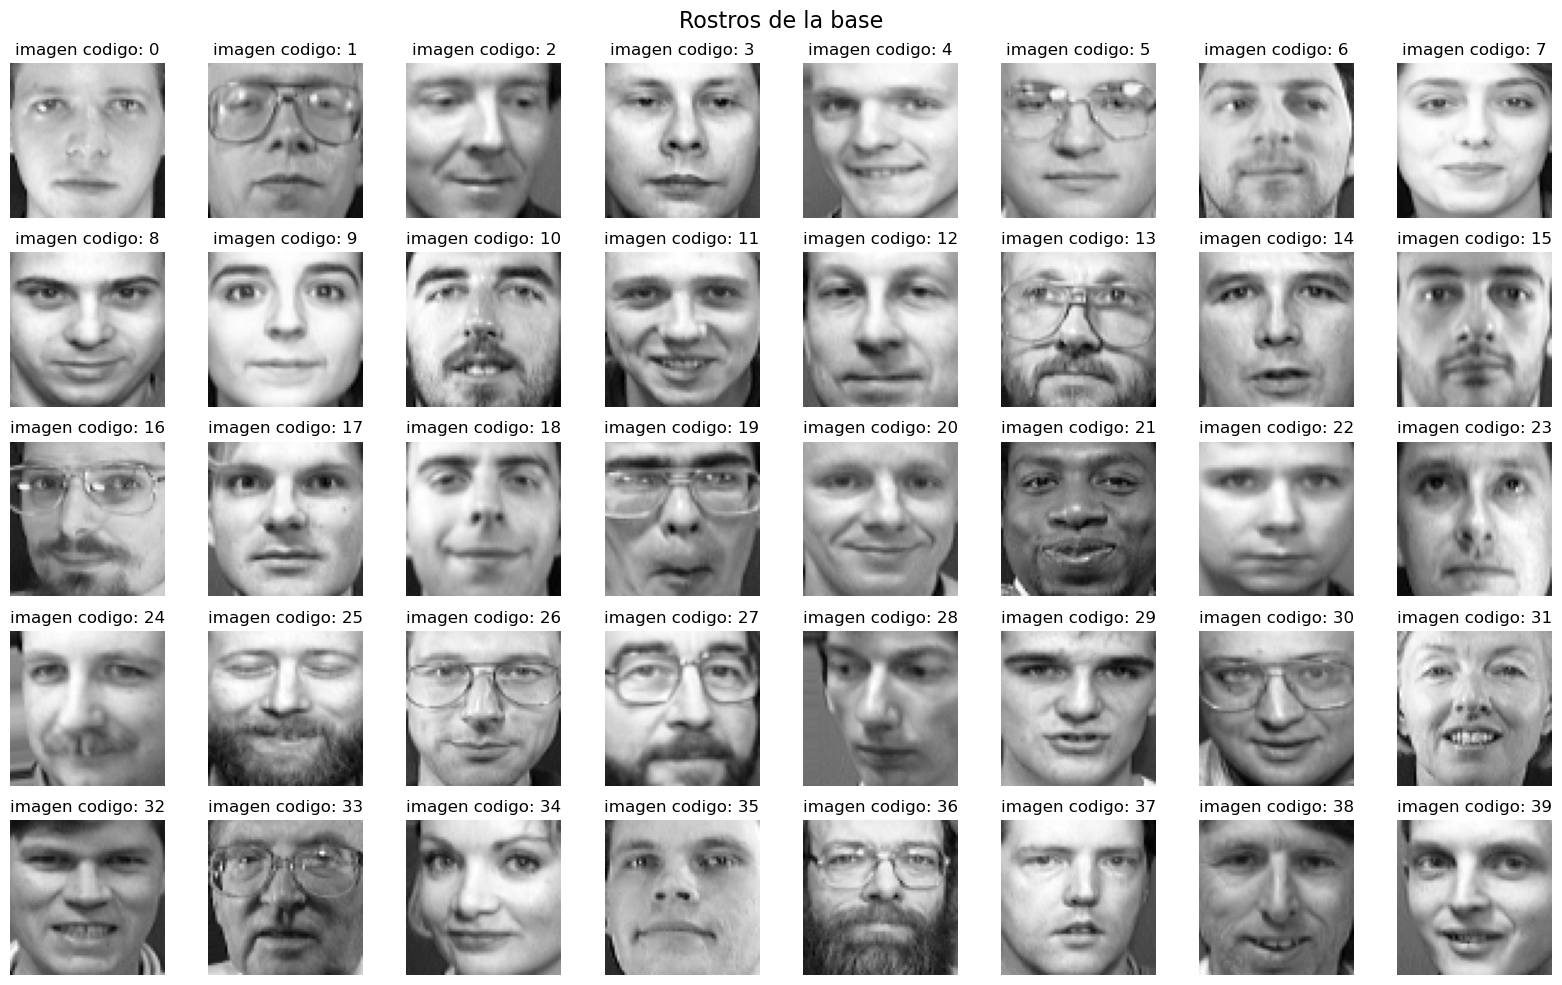

In [9]:
# cantidad de imagenes que se quieren graficar
num_images = len(df_images["target"].unique())

# Determinar el tamaño del grid de imagenes
rows = 5
cols = int(np.ceil(num_images/rows))

fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
axes = axes.flatten()

# loop desde 0 hasta le tamaño de las imagenes filtradas
for i in df_images["target"].unique():
    # Filtro para identificar las imagenes con marca igual a i
    c = df_images["target"] == i

    ax = axes[i]
    #traer la imagen i de la persona cuyo valor en target es igual a i
    # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
    ax.imshow(df_images[c].iloc[i%10,:-1].to_numpy().reshape(h,w), cmap='gray')
    # eliminar axis
    ax.set_title("imagen codigo: {}".format(i))
    ax.axis('off')

# eliminar axis de las imagenes vacias
for j in range(i + 1, rows * cols):
    axes[j].axis('off')

fig.suptitle("Rostros de la base", fontsize=16)
plt.tight_layout()
plt.show()

Se itera sobre el data frame creado en el punto anterior y se grafica 1 imágen de las 10 imagenes disponibles de cada persona. Podemos observar los rostros de las 40 personas y notamos que que se trata de personas de diferentes sexos, diferentes edades, con distintos encuadres y expresiones, ademas de por supuesto rasgos faciales

#### 2.3. Transforme las imágenes en un data frame donde cada columna contiene los valores estandarizados del nivel de gris en la imagen y una columna con la etiqueta de cada imagen.

In [10]:
scaler = StandardScaler()
df_images_scaled = pd.DataFrame(scaler.fit_transform(df_images.iloc[:,:-1]))

# convertir los datos de targuet en un dataframe
target = olivetti_faces["target"]
target = pd.DataFrame(target, columns=['target'])
# unir el targuet con la base de datos original, se asume que los targuet estan
# ordenados de la misma manera que el dataset de entrada
df_images_scaled = df_images_scaled.join(target)

print("valores descriptivos base original \n")
display(df_images.describe().loc[["count","mean","std"],:])
print("valores descriptivos base estandarizada \n")
display(df_images_scaled.describe().loc[["count","mean","std"],:])

valores descriptivos base original 



,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,0.400134,0.434236,0.476281,0.518481,0.554845,0.588729,0.621426,0.647510,0.664814,0.676591,...,0.367221,0.363027,0.355506,0.340196,0.338657,0.335909,0.321415,0.313647,0.310455,19.500000
std,0.180695,0.189504,0.194742,0.193313,0.188593,0.178481,0.167109,0.155024,0.147616,0.143583,...,0.181861,0.181611,0.188709,0.186088,0.189256,0.195280,0.187842,0.183616,0.180635,11.557853


valores descriptivos base estandarizada 



,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
count,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,4.000000e+02,400.000000,...,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,400.000000,400.000000,400.000000
mean,1.907349e-08,-9.536743e-09,1.907349e-08,9.536743e-09,1.907349e-08,9.536743e-09,1.907349e-08,0.000000,-1.907349e-08,0.000000,...,-4.768371e-09,4.768371e-09,-9.536743e-09,-1.192093e-09,1.430511e-08,-9.536743e-09,9.536743e-09,0.000000,0.000000,19.500000
std,1.001252e+00,1.001253e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252,1.001252e+00,1.001252,...,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001252e+00,1.001253e+00,1.001252,1.001252,11.557853


En este paso procedimos a estandarizar los datos ya que este es un pre-requisito para correr el algoritmo k-means y k-medoides. Se muestran las medidas de la media y la desviacion estandar para los datos sin estandarizar y luego de ser estandarizados, validando asi que para cada pixel de la imagen se han estandarizado para tener media 0 y desviacion estandar igual al 1

### 3. Clasificando de forma no supervisada

En esta sección trataremos de clasificar las imágenes de los individuos de forma no supervisada. Para ello utilizaremos los algoritmos de k-medias y k-medoides. Dado que sabemos que el dataset consta de 40 personas diferentes, utilizaremos esta información para pedirle a los algoritmos que encuentren k=40 clusters y examinaremos su precisión.


#### 3.1. Implemente k-medias sobre los datos estandarizados en el punto anterior. Al implementar utilice  `random_state=123` y `n_init=10`. (Esto puede tomar mucho tiempo y requerir mucho RAM, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [11]:
kmeans = KMeans(n_clusters = 40, random_state = 123, n_init=10)
kpredict = kmeans.fit_predict(df_images_scaled.iloc[:,:-1])

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


(40, 4096)


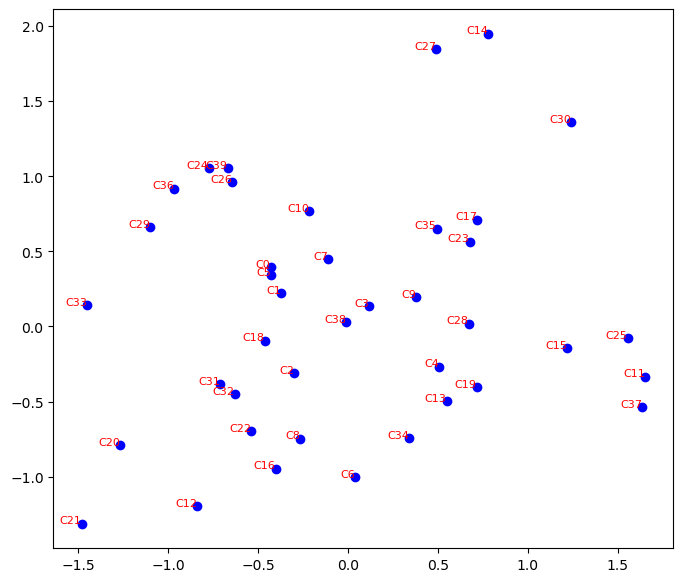

In [12]:
# Plotting Centroides
centroides = kmeans.cluster_centers_
print(centroides.shape)
fig, ax = plt.subplots(figsize=(8,7))
#g_centroides = plt.scatter(centroides[:,0], centroides[:,1], color = "blue", label = "Centroides")
plt.scatter(centroides[:,0], centroides[:,1000], color = "blue", label = "Centroides")
# Add labels to the centroids
for i, centroid in enumerate(centroides):
    ax.text(centroid[0], centroid[1000], f'C{i}', fontsize=8, ha='right', color='red')
plt.show()

En la gráfica se pueden ver los centroides identificados por el algoritmo graficados en dos dimensiones tomando las columnas correspondientes al indice 0 y 1000.
El array centroide tiene forma 40x4096 ya que se genera un centroide por cada cluster y cada centroide es el vector de las medias de los 4096 atributos de las observaciones correspondientes a dicho cluster.
Si cambiamos los indices la imagen puede cambiar considerablemente ya que el valor de los centroides será distinto por lo que la gráfica en si no nos permite sacar ninguna conclusión.

In [13]:
def homologar_llave_cluster_llave_dataset(df, col_homologar):
    '''
        Funcion para obtener la moda de los cluster originiales en los cluster predichos

        parametros:
            df: datos con la informacion de las imagenes y los valores reales
            col_homologar: nombre de la columna para la cual se quiere conocer la moda de los valores reales

        retorno:
            diccionario cuyas llaves son los valores de los clusters identificados por el algoritmo y los valores corresponden a las etiquetas originales
    '''


    # cantidad de etiquetas del targuet contenida en cada cluster
    info_cluster = df.groupby([col_homologar,"target"])[[0]].count().sort_values(by=[col_homologar,0], ascending = False)

    # seleccionar la moda
    homologa_pred_vs_cluster = info_cluster.groupby(col_homologar).head(1).reset_index()[[col_homologar,"target"]]

    # retorna diccionario para una mejor homologacion
    dict_homologador = dict(zip(homologa_pred_vs_cluster[col_homologar],homologa_pred_vs_cluster["target"]))
    return dict_homologador

In [14]:
metodo = "kmeans"
nombre_metodo = "predict_{}".format(metodo)
nombre_col_homolog = "homolog_{}".format(metodo)

# asignacion de las predicciones
df_images_scaled[nombre_metodo] = kpredict
# aplicar el homologador
dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
# asignacion de nuevos creando una nueva variable
df_images_scaled[nombre_col_homolog] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)

El resultado del algoritmo Kmeans es una asignacion de los datos a uno de los K clusters, pero estos clusters generados no hacen referencia al id de cada individuo por lo que es necesario realizar una interpretacion de aquellos clusters, en este caso particular como se cuenta con las etiquetas reales de las fotos, se puede determinar cual es la moda para cada cluster y asi determinar que el cluster $K_i$ corresponde a las fotos del individuo(moda).
Creamos una función para realizar dicho paso pero debemos aclarar que este procedimiento no es 100% perfecto ya que en algunos casos existe más de una moda por lo que el algoritmo eligirá una de ellas.
Nos gustaría aclarar que en este ejercicio ya se conocen los ids de las personas y resulta fácil caracterizar cada cluster, sin embargo hacerlo implica que no estamos haciendo un ejercicio estrictamente no supervisado. En escenarios donde no contemos con una variable respuesta para caracterizar el cluster seria necesario analizar cada centroide en el contexto del problema analizado.

#### 3.2. Evalúe la precisión del algoritmo para agrupar las imágenes de los individuos.

In [15]:
dict_silhouette = {}
dict_precision = {}
dict_class_report = {}
dict_confusion_matrix = {}

In [16]:
# Creacion de las variables verdaderas y las predichas para el calculo de metricas
y_true = df_images_scaled.loc[:,"target"]
y_pred_homolog = df_images_scaled.loc[:,nombre_col_homolog]
y_pred_original = kpredict

In [17]:
columns_y = ["target",nombre_metodo,nombre_col_homolog]
data = df_images_scaled.drop(columns=columns_y)

silhouette = silhouette_score(data, y_pred_original)
dict_silhouette[metodo] = silhouette

print(f"Silhouette Score Kmeans: {silhouette}")


Silhouette Score Kmeans: 0.14944997429847717


Calculamos el coeficiente Silhouette utilizando los datos escalados y las asignaciones de clusters realizadas por el algortimo. Esta métrica mide la calidad del clustering ya que mide tanto las distancias entre cada observacion al interior del cluster (a) y la distancia de las observaciones al grupo vecino más cercano (b), cuanto mayor sea a y menor sea b el coeficiente se acercara más a 1 lo que implica una buena clusterización. En este caso vemos que el valor es muy bajo lo que indica que el resultado del algoritmo no es optimo.

In [18]:
precision = precision_score(y_true, y_pred_homolog,zero_division=0, average ='weighted')
dict_precision[metodo] = precision

print(f"Precision Score (Weighted Avg) Kmeans: {precision}")

Precision Score (Weighted Avg) Kmeans: 0.6115353717284495


Otra métrica que utilizamos es la precisión, esta mide la proporción de verdaderos positivos entre el total de elementos clasificados como positivos. Para este caso es necesario utilizar las clasificaciones originales y por eso se utilza LLevado a nuestro ejemplo esto nos dice cuantos de los elementos identificados como pertenecientes a determinado cluster eran realmente imagenes de la misma persona identificada por ese cluster. En este caso estamos utilizando el Weighted Avg y nos da un 61%.

In [19]:
report = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)["weighted avg"]
dict_class_report[metodo] = report
print(report)

{'precision': 0.6115353717284495, 'recall': 0.6625, 'f1-score': 0.6193079220808415, 'support': 400.0}


In [20]:
report2 = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)

#Extraer las precisiones
precisions = {label: metrics['precision'] for label, metrics in report2.items() if label != 'accuracy'}

# Contar las clases con precisión mayor a 0.7
num_classes_above_07 = sum(precision > 0.7 for precision in precisions.values())

print(f"Número de clases con precisión mayor a 0.7: {num_classes_above_07}")



Número de clases con precisión mayor a 0.7: 17


Para poder interpretar en terminos de los datos que tenemos los resultados de estas métricas decidimos contar en cuantas clases la precisión es mayor al 70%. Como podemos ver menos del 50% de las clases tienen una precisión mayor al 70%. Esto implica que mas de la mitad de las personas el algoritmo tiene un resultado suboptimo.

<Axes: >

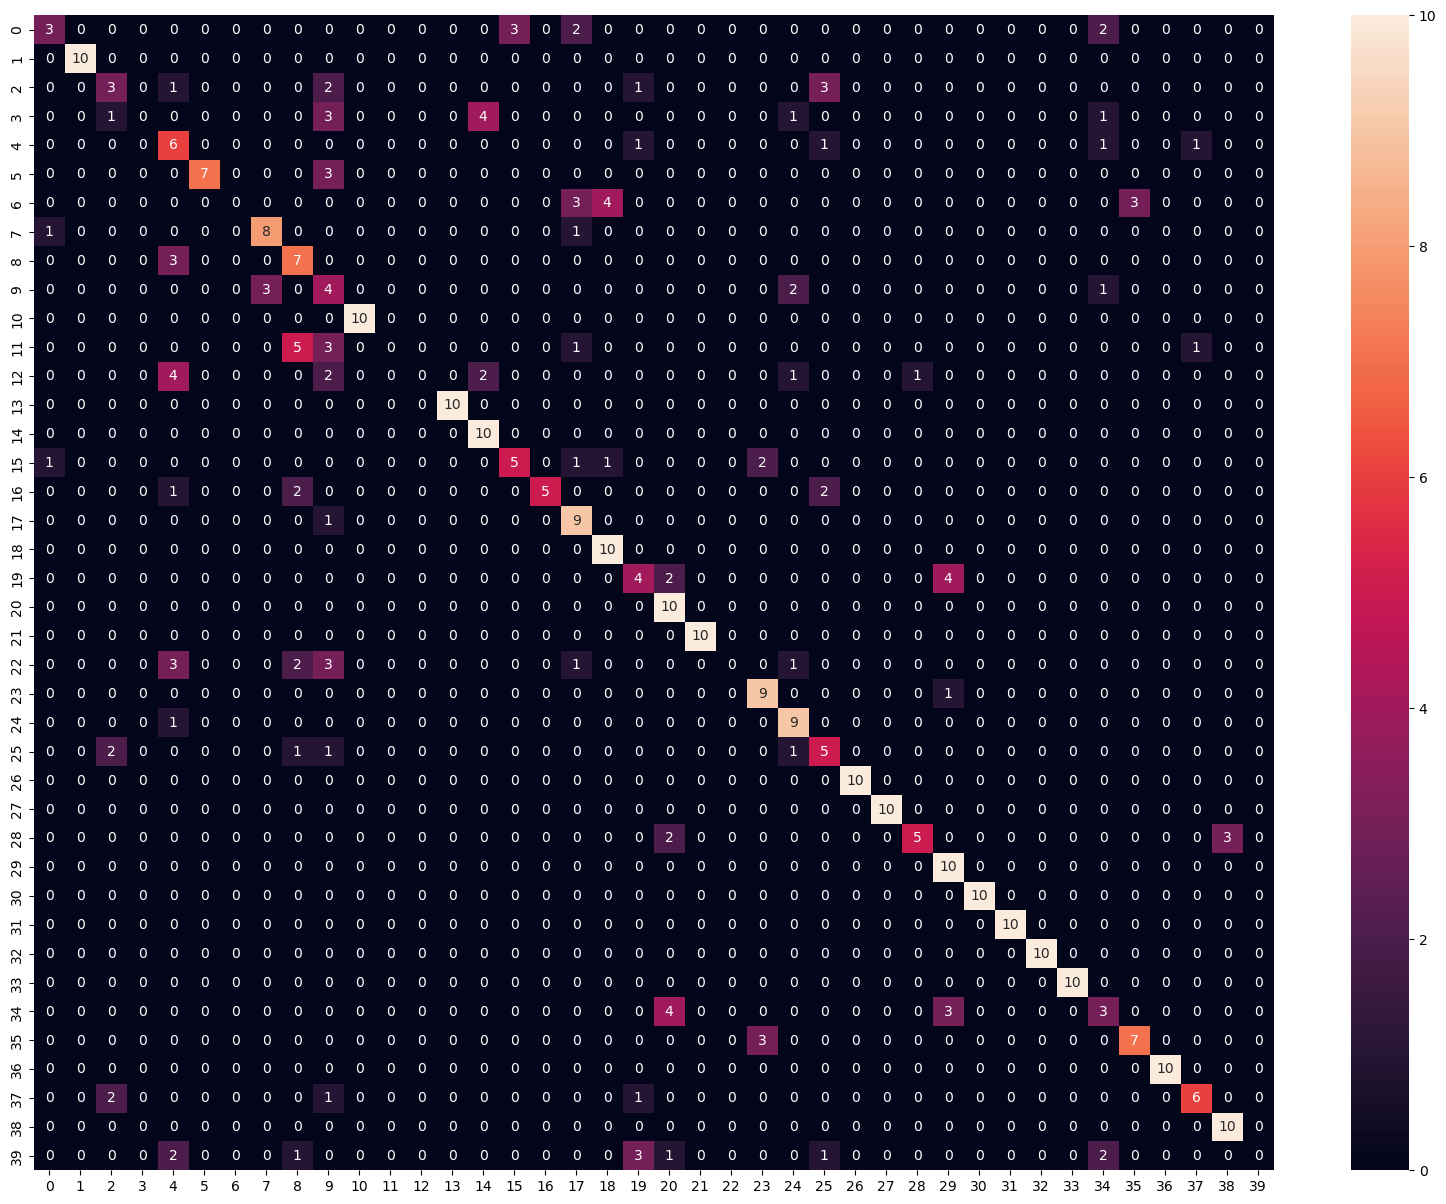

In [21]:
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(confusion_matrix(y_true, y_pred_homolog), annot=True, ax=ax)

En ese mapa de calor podemos ver la matriz de confusión que nos muestra como fueron asignadas las imagenes de cada persona. En el eje vertical se tiene la etiqueta original y en el eje horizontal la etiqueta resultante del re-labeling de los clusters formados por el algoritmo. En la diagonal podemos ver la cantidad de imágenes que fueron correctamente asignadas a cada cluster y fuera de la diagonal las imagenes que fueron asignadas a clusters de forma incorrecta.
Como ejemplo, aqui podemos observar la diferencia entre el cluster 14 y el cluster 27. En el 14 se identifican correctamente las 10 imágenes pero se clasifican 6 imágenes adicionales que no pertenecen a ese cluster sino a los clusters 12 y 3. En el caso de la clase 27 la asignación fue perfecta porque solo se asignaron a dicha clase las 10 imagenes correspondientes.

In [22]:
def graficar_imagenes_individuo_original(i):
    num_images = sum(df_images["target"] == i)

    # Determinar el tamaño del grid de imagenes
    cols = 5
    rows = int(np.ceil(num_images/cols))

    fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
    axes = axes.flatten()


    for n in np.arange(0,num_images):
        # Filtro para identificar las imagenes con marca igual a i
        c = df_images["target"] == i

        ax = axes[n]
        #traer la imagen i de la persona cuyo valor en targuet es igual a i
        # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
        ax.imshow(df_images[c].iloc[n,:-1].to_numpy().reshape(h,w), cmap='gray')
        # eliminar axis
        ax.set_title("imagen codigo: {}".format(i))
        ax.axis('off')

        # eliminar axis de las imagenes vacias
        for j in range(i + 1, rows * cols):
            axes[j].axis('off')

    fig.suptitle("Rostros del individuo {}".format(i), fontsize=16)
    plt.tight_layout()
    plt.show()

def graficar_imagenes_individuo_predicho(i,col_preds):

    c = df_images_scaled[col_preds] == i
    index_img = df_images_scaled[c].index.values

    num_images = len(index_img)

    if num_images > 0:

        # Determinar el tamaño del grid de imagenes
        cols = 5
        rows = int(np.ceil(num_images/cols))

        fig, axes = plt.subplots(rows, cols, figsize=(2 * cols, 2 * rows))
        axes = axes.flatten()


        for n, idx in enumerate(index_img):
            # Filtro para identificar las imagenes con marca igual a i

            ax = axes[n]
            #traer la imagen i de la persona cuyo valor en targuet es igual a i
            # me parecio traer la imagen i%10 realmente en .iloc[] se puede colocar cualquier numero entre [0,39]
            ax.imshow(df_images.iloc[idx,:-1].to_numpy().reshape(h,w), cmap='gray')
            # eliminar axis
            ax.set_title("imagen codigo: {}".format(df_images_scaled["target"][idx]))
            ax.axis('off')

            # eliminar axis de las imagenes vacias
            for j in range(i + 1, rows * cols):
                axes[j].axis('off')

        fig.suptitle("Predicciones rostros del individuo {}".format(i), fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print("no existen imagenes con predicciones para el rostro {}".format(i))

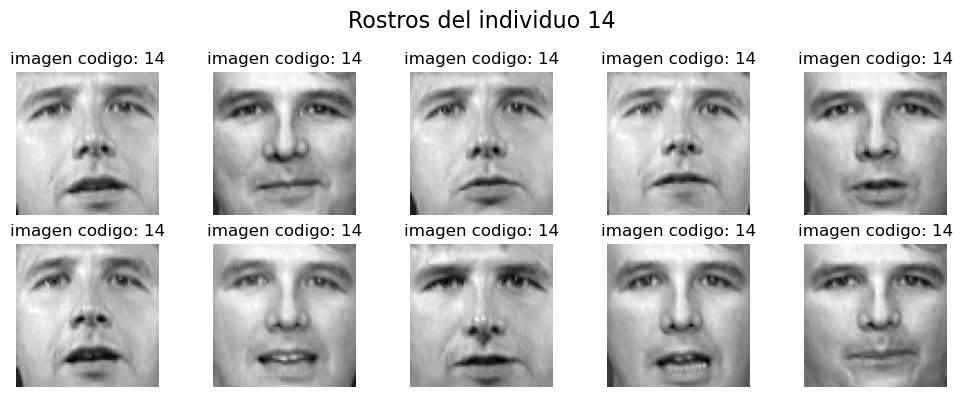

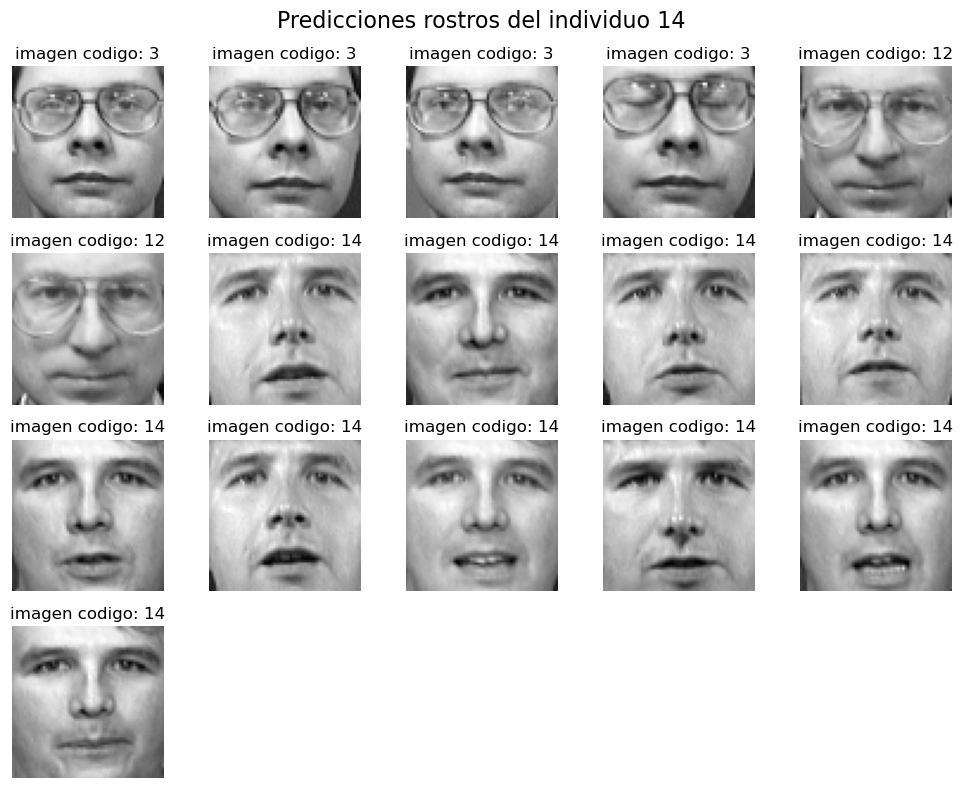

In [23]:
# cantidad de imagenes que se quieren graficar
n = 14

graficar_imagenes_individuo_original(n)

graficar_imagenes_individuo_predicho(n,nombre_col_homolog)

Podemos ver para la clase 14 mencionada anteriormente cómo se identifican las 10 imágenes originales pero se asignan equivocamente 6 imagenes pertenecientes a otras 2 clases. Resulta curioso que las 6 imágenes incorrectamente asignadas corresponden a individues con gafas. Al volver a la matriz de confusión y observar como clasifica el algoritmo esas dos clases vemos que no logra asignar un numero  grande de imagenes a una misma clase sino que se ve una asignación bastante dispersa. Esto nos puede dar el indicio de que quizá el hecho de tener fotos con gafas dificulta el ejercicio.

#### 3.3. Usando PCA reduzca la dimensión de la matriz de predictores. Retenga el numero de componentes que explican el 95% de la varianza y vuelva a utilizar k-medias para clasificar las imágenes comentado si la precisión mejoró.

In [24]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,-0.499903,-0.351181,-0.302961,-0.395361,-0.137608,0.104953,0.213296,0.194895,0.171393,0.065267,...,1.834412,1.663787,1.598077,1.621725,0.726428,-1.092090,-0.959562,-0.898275,-0.831520,-0.850457
1,0.301499,0.194640,0.185686,0.203914,0.213404,0.290404,0.361849,0.355027,0.311534,0.180529,...,-1.376154,-1.157252,-1.249632,-1.096954,-1.007794,-0.982782,-0.938375,-0.898275,-0.876585,-0.873362
2,-0.454109,-0.176519,0.079458,0.054095,0.169528,0.383129,0.361849,0.248272,0.255478,0.151713,...,-1.752392,-1.293754,-0.999033,-1.162729,-1.141196,-1.004644,-0.980749,-0.964354,-0.899118,-0.873362
3,-1.118128,-1.268161,-1.450221,-1.679522,-1.936544,-2.236356,-2.262576,-1.566562,-1.230019,-1.116164,...,1.759164,1.481785,1.620859,1.753274,2.082678,2.143408,2.197309,2.295495,2.390682,2.379127
4,0.553368,0.587631,0.546860,0.546357,0.498601,0.568579,0.436125,0.435093,0.395618,0.382236,...,-1.050081,-1.134501,-1.021815,-0.965405,-0.874393,-0.851614,-0.811252,-0.766119,-0.763921,-0.758838


In [25]:
data = df_images_scaled.drop(columns=columns_y)
n = min(data.shape)

model = PCA(n_components=n)
images_pca_total = model.fit_transform(data)

In [26]:
print(images_pca_total.shape)

(400, 400)


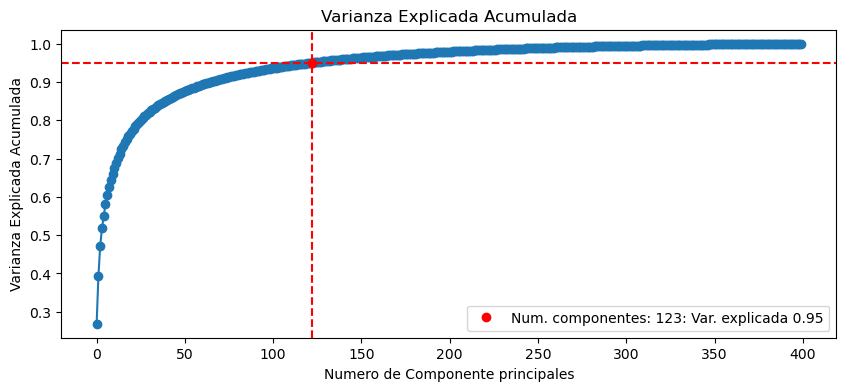

In [27]:
# Calculo de la varianza acumuladade cada componente de PCA
cumsum_var = model.explained_variance_ratio_.cumsum()
# Calculo del indice donde el valor es mayor o igual al 95% de la varianza explicada
indx = np.argmax(model.explained_variance_ratio_.cumsum()  >= 0.95)

fig, ax = plt.subplots(figsize=(10,4))

ax.plot(range(0, len(cumsum_var + 1)),cumsum_var , marker='o')
ax.plot(indx, cumsum_var[indx], 'ro', label=f'Num. componentes: {indx + 1}: Var. explicada {cumsum_var[indx]:.2f}')

ax.axhline(y = cumsum_var[indx], color = 'r', linestyle = '--')
ax.axvline(x = indx, color = 'r', linestyle = '--')

ax.set_xlabel('Numero de Componente principales')
ax.set_ylabel('Varianza Explicada Acumulada')
ax.set_title('Varianza Explicada Acumulada')
ax.legend()

In [28]:
images_pca_95 = images_pca_total[:,:indx+1]
images_pca_95.shape

(400, 123)

In [29]:
kmeans95 = KMeans(n_clusters = 40, random_state = 123, n_init=10)
kpredict95 = kmeans.fit_predict(images_pca_95)

c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [30]:
metodo = "kmeans_pca"
nombre_metodo = "predict_{}".format(metodo)

In [31]:
nombre_col_homolog = "homolog_{}".format(metodo)

# asignacion de las predicciones
df_images_scaled[nombre_metodo] = kpredict95
# aplicar el homologador
dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
# asignacion de nuevos
df_images_scaled[nombre_col_homolog] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)
columns_y = np.append(columns_y,[nombre_metodo,nombre_col_homolog])

In [32]:
# Creacion de las variables verdaderas y las predichas para el calculo de metricas
y_true = df_images_scaled.loc[:,"target"]
y_pred_homolog = df_images_scaled.loc[:,nombre_col_homolog]
y_pred_original = kpredict95

In [33]:

data = df_images_scaled.drop(columns=columns_y)
silhouette = silhouette_score(data, y_pred_original)
dict_silhouette[metodo] = silhouette
print(f"Silhouette Score Kmeans con PCA: {silhouette}")

Silhouette Score Kmeans con PCA: 0.15341134369373322


In [34]:
precision = precision_score(y_true, y_pred_homolog,zero_division=0, average="weighted")
dict_precision[metodo] = precision

print(f"Precision Score (weighted) Kmeans con PCA: {precision}")


Precision Score (weighted) Kmeans con PCA: 0.5978003173726858


In [35]:
report = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)["weighted avg"]
dict_class_report[metodo] = report
print(report)

{'precision': 0.5978003173726858, 'recall': 0.6375, 'f1-score': 0.5955965937327039, 'support': 400.0}


In [36]:
report2 = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)

#Extraer las precisiones
precisions = {label: metrics['precision'] for label, metrics in report2.items() if label != 'accuracy'}

# Contar las clases con precisión mayor a 0.7
num_classes_above_07 = sum(precision > 0.7 for precision in precisions.values())

print(f"Número de clases con precisión mayor a 0.7: {num_classes_above_07}")

Número de clases con precisión mayor a 0.7: 20


<Axes: >

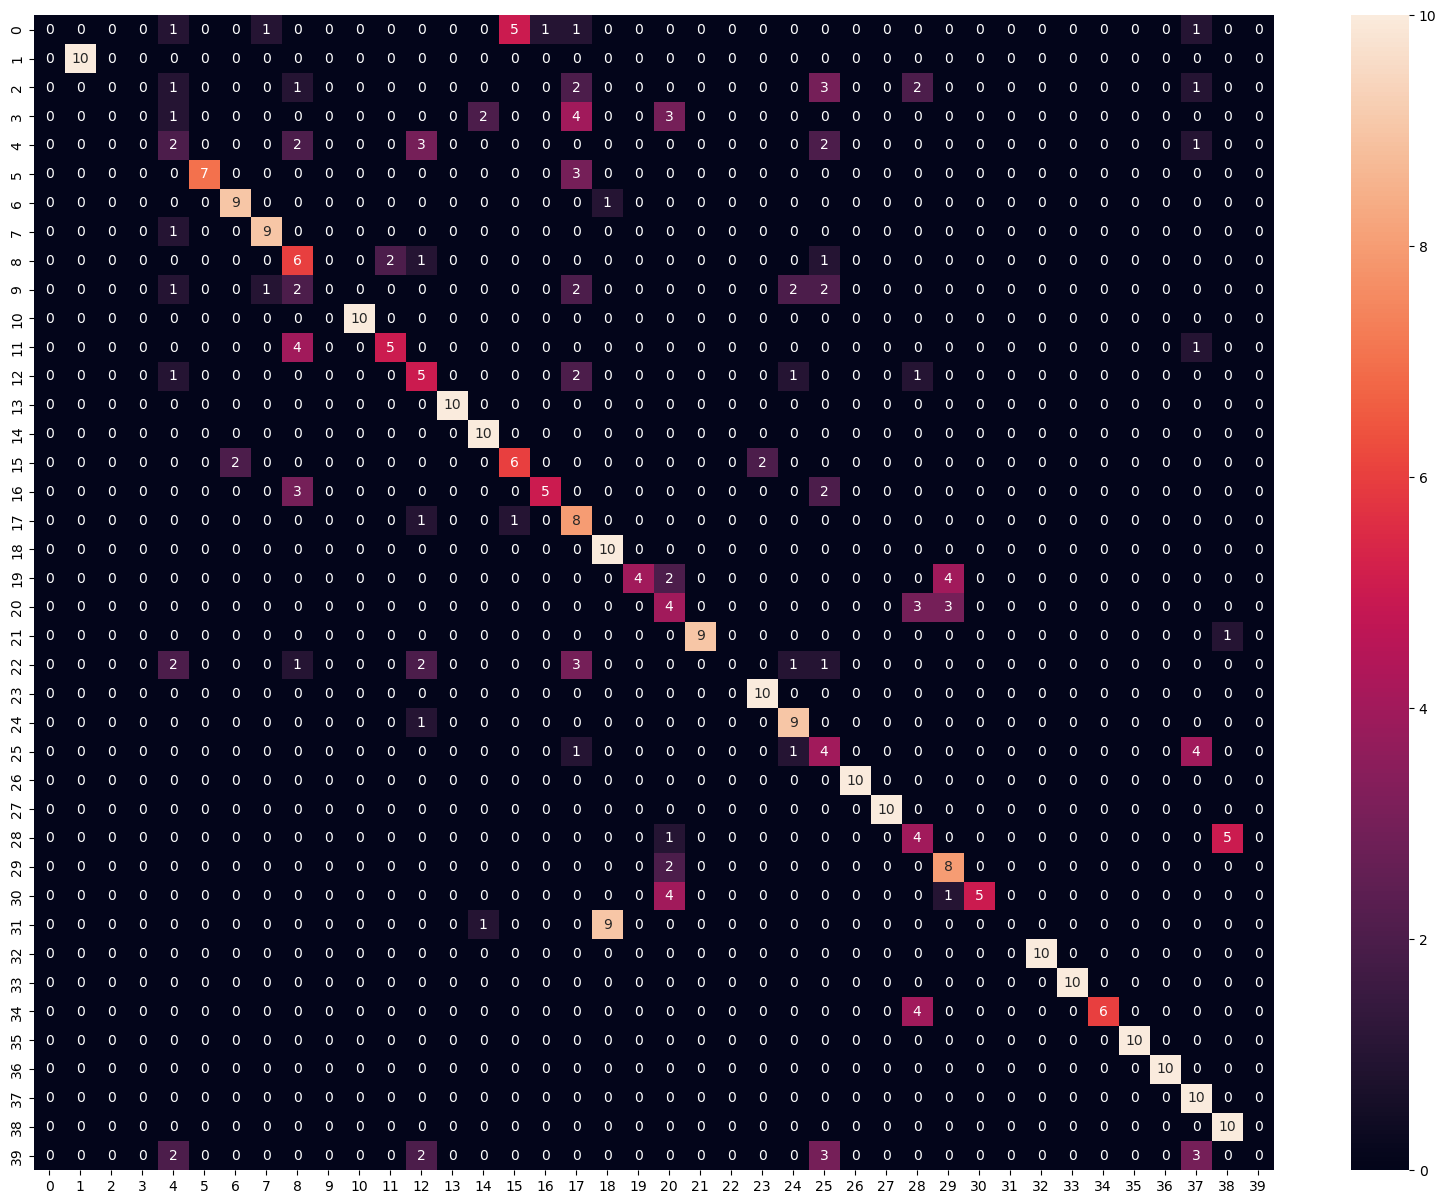

In [37]:
fig,ax = plt.subplots(figsize=(20,15))
sns.heatmap(confusion_matrix(y_true, y_pred_homolog), annot=True, ax=ax)

Aplicando PCA se logra reducir la dimensionalidad de 4096 variables a 123 componentes aún asi explicando el 95% de la varianza. Al correr el algoritmo con este set de datos notamos que hay muy poca variación en los resultados. Se generan las mismas métricas pero ahora para este conjunto de datos:
- La precisión cambia de 61% sin PCA a 59% con PCA
- El silhouette cambia de 0.14 a 0.15
- El número de clases en las cuales la precisión es mayor al 70% aumenta de 17 a 20 pero aun asi es baja.

El hecho de que el promedio global de precisión baja con PCA mientras que el número de clases con precisión mayor al 70% aumente puede resulta confuso, sin embargo esto se puede dar porque los valores de precision cambiaron por ejemplo de un 80 a 75 lo que termina afectando el promedio global pero no el conteo de clases que superan el umbral definido.  

En conclusión creemos que lo destacable de implementar PCA es que cumple con el objetivo de reducir la dimensionalidad sin impactar negativamente los resultados del algoritmo pero no aporta ninguna mejora significativa en la clasificación.




#### 3.4. Utilice ahora el algoritmo por  K-medoides (use el mismo random state a los puntos anteriores), comente si mejoró la precisión total y para cada grupo de imágenes.

In [38]:
!pip install scikit-learn-extra

In [39]:
# Utilice este espacio para escribir el código.

data = df_images_scaled.drop(columns=columns_y)
data_PCA = images_pca_95

iter_metricas = ["euclidean","manhattan","cosine"]

arr_precision_og = []
arr_precision_95 = []

for m in iter_metricas:

    print("Scores {m} \n".format(m=m))
    print("Estandar {m} \n".format(m=m))
    # metodo para Datos Estandar
    metodo = "kmediods_{}".format(m)
    nombre_metodo = "predict_{}".format(metodo)
    nombre_col_homolog = "homolog_{}".format(metodo)

    columns_y = np.append(columns_y,[nombre_metodo,nombre_col_homolog])

    Kmedoides = KMedoids(n_clusters = 40, metric = m, random_state = 123)
    Kmedoides.fit(data)


    df_images_scaled[nombre_metodo] = Kmedoides.labels_
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_col_homolog] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred_homolog = df_images_scaled.loc[:,nombre_col_homolog]
    y_pred_original = Kmedoides.labels_

    data = df_images_scaled.drop(columns=columns_y)
    silhouette = silhouette_score(data, y_pred_original)
    dict_silhouette[metodo] = silhouette
    print(f"Silhouette Score Kmedoides con PCA: {silhouette}")

    precision = precision_score(y_true, y_pred_homolog, average="weighted", zero_division=0)
    dict_precision[metodo] = precision
    print(f"Precision Score (weighted) Kmedoides con PCA: {precision}")

    report = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)


    # metodo para Datos PCA
    print("\n".format(m=m))
    print("PCA {m} \n".format(m=m))
    metodo = "kmediods_PCA_{}".format(m)
    nombre_metodo = "predict_{}".format(metodo)
    nombre_col_homolog = "homolog_{}".format(metodo)

    columns_y = np.append(columns_y,[nombre_metodo,nombre_col_homolog])


    Kmedoides_pca = KMedoids(n_clusters = 40, metric = m, random_state = 123)
    Kmedoides_pca.fit(data_PCA)


    df_images_scaled[nombre_metodo] = Kmedoides_pca.labels_
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_col_homolog] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred_homolog = df_images_scaled.loc[:,nombre_col_homolog]
    y_pred_original = Kmedoides_pca.labels_

    data = df_images_scaled.drop(columns=columns_y)
    silhouette = silhouette_score(data, y_pred_original)
    dict_silhouette[metodo] = silhouette
    print(f"Silhouette Score Kmeans con kmedoides y PCA: {silhouette}")

    precision = precision_score(y_true, y_pred_homolog, average="weighted", zero_division=0)
    dict_precision[metodo] = precision
    print(f"Precision Score (weighted) Kmedoides y PCA: {precision}")

    report = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)

Scores euclidean 

Estandar euclidean 

Silhouette Score Kmedoides con PCA: 0.022396547719836235
Precision Score (weighted) Kmedoides con PCA: 0.3770168584373706
{'precision': 0.3770168584373706, 'recall': 0.44, 'f1-score': 0.37388883915169907, 'support': 400.0}


PCA euclidean 

Silhouette Score Kmeans con kmedoides y PCA: 0.014417992904782295
Precision Score (weighted) Kmedoides y PCA: 0.4292224807972238
{'precision': 0.4292224807972238, 'recall': 0.445, 'f1-score': 0.39469206991957073, 'support': 400.0}
Scores manhattan 

Estandar manhattan 

Silhouette Score Kmedoides con PCA: 0.027824271470308304
Precision Score (weighted) Kmedoides con PCA: 0.4200209940128671
{'precision': 0.4200209940128671, 'recall': 0.47, 'f1-score': 0.4020770760895486, 'support': 400.0}


PCA manhattan 

Silhouette Score Kmeans con kmedoides y PCA: -0.04371243342757225
Precision Score (weighted) Kmedoides y PCA: 0.33011691110348396
{'precision': 0.33011691110348396, 'recall': 0.4125, 'f1-score': 0.34200540846

In [40]:
df_images_scaled.head().columns.values[-60:]
#["kmediods_cosine"]

array([4053, 4054, 4055, 4056, 4057, 4058, 4059, 4060, 4061, 4062, 4063,
       4064, 4065, 4066, 4067, 4068, 4069, 4070, 4071, 4072, 4073, 4074,
       4075, 4076, 4077, 4078, 4079, 4080, 4081, 4082, 4083, 4084, 4085,
       4086, 4087, 4088, 4089, 4090, 4091, 4092, 4093, 4094, 4095,
       'target', 'predict_kmeans', 'homolog_kmeans', 'predict_kmeans_pca',
       'homolog_kmeans_pca', 'predict_kmediods_euclidean',
       'homolog_kmediods_euclidean', 'predict_kmediods_PCA_euclidean',
       'homolog_kmediods_PCA_euclidean', 'predict_kmediods_manhattan',
       'homolog_kmediods_manhattan', 'predict_kmediods_PCA_manhattan',
       'homolog_kmediods_PCA_manhattan', 'predict_kmediods_cosine',
       'homolog_kmediods_cosine', 'predict_kmediods_PCA_cosine',
       'homolog_kmediods_PCA_cosine'], dtype=object)

In [41]:
dc = classification_report(y_true,df_images_scaled["homolog_kmeans"],output_dict=True, zero_division=0)
dc = {k: v["precision"] for k,v in dc.items() if isinstance(v, dict)}
df_comparar = pd.DataFrame.from_dict(dc,orient="index")


dc = classification_report(y_true,df_images_scaled["homolog_kmediods_cosine"],output_dict=True, zero_division=0)
dc = {k: v["precision"] for k,v in dc.items() if isinstance(v, dict)}
df_comparar = pd.concat([df_comparar,pd.DataFrame.from_dict(dc,orient="index")],axis=1)
df_comparar.columns = ["homolog_kmeans","homolog_kmediods_cosine"]
df_comparar["diff"] = df_comparar["homolog_kmeans"] - df_comparar["homolog_kmediods_cosine"]
df_comparar

,homolog_kmeans,homolog_kmediods_cosine,diff
0,0.600000,0.750000,-0.150000
1,1.000000,0.666667,0.333333
2,0.375000,1.000000,-0.625000
3,0.000000,1.000000,-1.000000
4,0.285714,0.428571,-0.142857
5,1.000000,0.333333,0.666667
6,0.000000,0.315789,-0.315789
7,0.727273,0.428571,0.298701
8,0.388889,0.875000,-0.486111
9,0.173913,0.857143,-0.683230


In [42]:
(df_comparar["homolog_kmeans"]> 0.7).sum()
(df_comparar["homolog_kmediods_cosine"]> 0.7).sum()

9

In [43]:
report2 = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)

#Extraer las precisiones
precisions = {label: metrics['precision'] for label, metrics in report2.items() if label != 'accuracy'}

# Contar las clases con precisión mayor a 0.7
num_classes_above_07 = sum(precision > 0.7 for precision in precisions.values())

print(f"Número de clases con precisión mayor a 0.7: {num_classes_above_07}")

Número de clases con precisión mayor a 0.7: 12


Text(0.5, 1.0, 'Número de clases Kmedoides con precisión mayor a 0.7: 9')

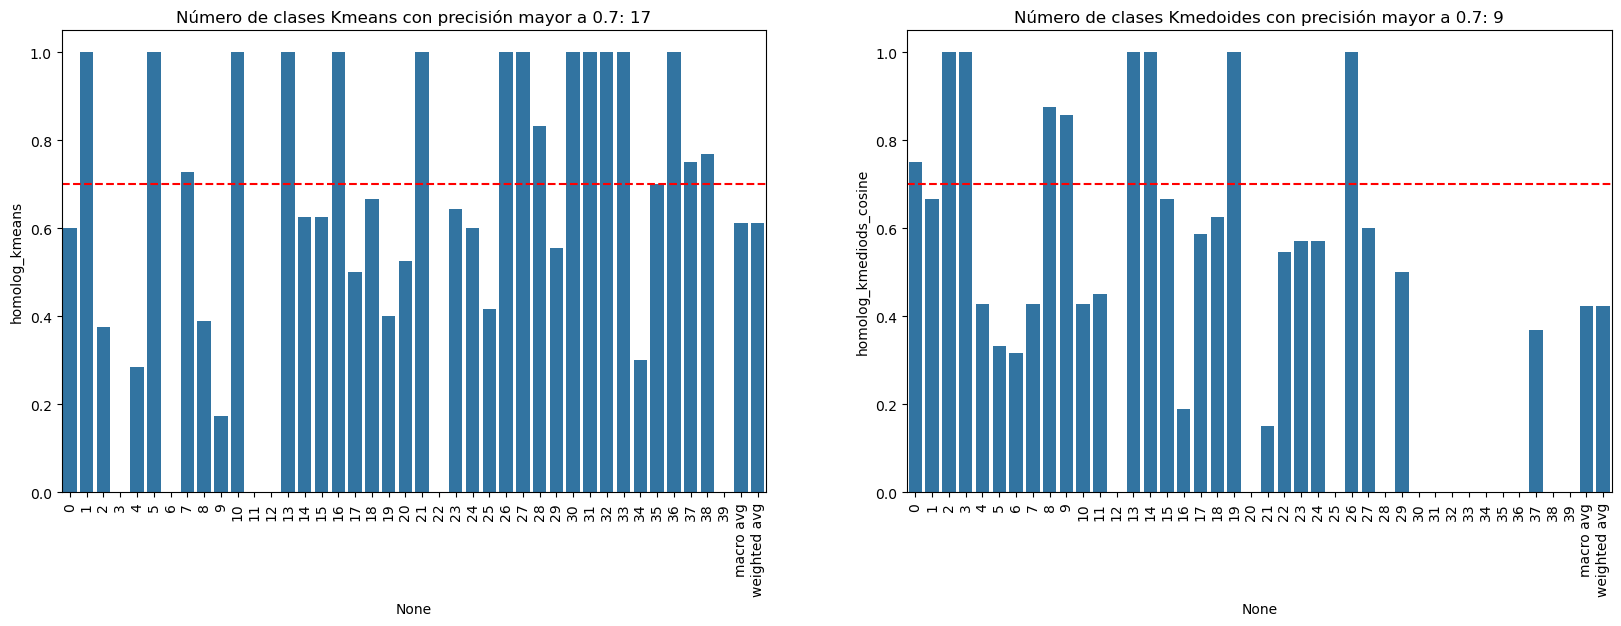

In [44]:
fig, ax = plt.subplots(1,2,figsize=(10*2,6))
axs = ax.flatten()


sns.barplot(data=df_comparar, x=df_comparar.index, y = "homolog_kmeans",ax=ax[0])
ax[0].tick_params(axis='x', rotation=90)
ax[0].axhline(0.7, linestyle = "--", color = "r", label="umbral elegido")
num_classes_above_07 = (df_comparar["homolog_kmeans"]> 0.7).sum()
text_title = f"Número de clases Kmeans con precisión mayor a 0.7: {num_classes_above_07}"
ax[0].set_title(text_title)


sns.barplot(data=df_comparar, x=df_comparar.index, y = "homolog_kmediods_cosine",ax=ax[1])
ax[1].tick_params(axis='x', rotation=90)
ax[1].axhline(0.7, linestyle = "--", color = "r", label="umbral elegido")
num_classes_above_07 = (df_comparar["homolog_kmediods_cosine"]> 0.7).sum()
text_title = f"Número de clases Kmedoides con precisión mayor a 0.7: {num_classes_above_07}"
ax[1].set_title(text_title)

(Utilice este espacio para describir el procedimiento, análisis y conclusiones)

### 4. Número de clusters óptimo

En el punto anteriores utilizamos nuestro conocimiento previo sobre los datos para elegir el número de clusters. En este punto, verifique si 40 es realmente el número de cluster que usted elegiría según los criterios estudiados en los cuadernos teóricos. Discuta los resultados obtenidos.

#### Consideraciones
1. Dado que en los ejercicios anteriores se observa que con **KMeans** y **PCA** se obtiene una mejor metrica de silhouette, se decide que la calibracion del parametro k se realizará unicamente con este método y con el dataset reducido. 
2. Para realizar la calibracion del parametro $k$ se iteraron distintos valores, empezando en 0 e iterando hasta llegar a 400 con pasos de 50, (realmente 0 no se escoje y se reemplaza por 2 ya que es el numero mínimo de clusters que se pueden realizar)
3. durante la iteracion se obtienen las medidas de **varianza intra cluster** y **Silhouette** con estas medidas se puede elegir un numero adecuado de clusters para el dataset.

In [45]:
arr_inertia = []
arr_silhouete = []

arr_iteracion = np.arange(0,400+1,50)

for i in arr_iteracion:

    if i == 0:
      i = 2
    elif i == data_PCA.shape[0]:
      i = data_PCA.shape[0] - 1
    print(i)

    metodo = "kmeans_pca_n{}".format(i)
    nombre_metodo = "predict_{}".format(metodo)
    nombre_col_homolog = "homolog_{}".format(metodo)

    data = data_PCA

    kmeans_iter = KMeans(n_clusters = i, random_state = 123, n_init=10)
    kpredict = kmeans_iter.fit_predict(data)

    arr_inertia.append(kmeans_iter.inertia_)

    df_images_scaled[nombre_metodo] = kpredict
    # aplicar el homologador
    dict_homologa_kmeans = homologar_llave_cluster_llave_dataset(df_images_scaled,nombre_metodo)
    # asignacion de nuevos
    df_images_scaled[nombre_col_homolog] = df_images_scaled[nombre_metodo].map(dict_homologa_kmeans)

    columns_y = np.append(columns_y,nombre_metodo)


    # Creacion de las variables verdaderas y las predichas para el calculo de metricas
    y_true = df_images_scaled.loc[:,"target"]
    y_pred_original = kpredict
    y_pred_homolog = df_images_scaled.loc[:,nombre_col_homolog]

    #data = df_images_scaled.drop(columns=columns_y)
    data = data_PCA

    silhouette = silhouette_score(data, y_pred_original)
    dict_silhouette[metodo] = silhouette
    arr_silhouete.append(silhouette)
    print(silhouette)

    precision = precision_score(y_true, y_pred_homolog, average="micro")
    dict_precision[metodo] = precision

    print(precision)

    report = classification_report(y_true, y_pred_homolog, zero_division=0, output_dict=True)["weighted avg"]
    dict_class_report[metodo] = report
    print(report)

2


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.17536747
0.05
{'precision': 0.002896535743251072, 'recall': 0.05, 'f1-score': 0.0054370339685169845, 'support': 400.0}
50


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.20437343
0.75
{'precision': 0.7448529704944178, 'recall': 0.75, 'f1-score': 0.7215541619476832, 'support': 400.0}
100


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.2532099
0.89
{'precision': 0.8917578255078255, 'recall': 0.89, 'f1-score': 0.8851992485330586, 'support': 400.0}
150


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.27073836
0.9675
{'precision': 0.9730032467532468, 'recall': 0.9675, 'f1-score': 0.9679875323335076, 'support': 400.0}
200


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.23216207
0.985
{'precision': 0.9880844155844156, 'recall': 0.985, 'f1-score': 0.9855639097744361, 'support': 400.0}
250


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.2029636
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}
300


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.15140046
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}
350


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.083474405
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}
399


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


0.0039969636
1.0
{'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 400.0}


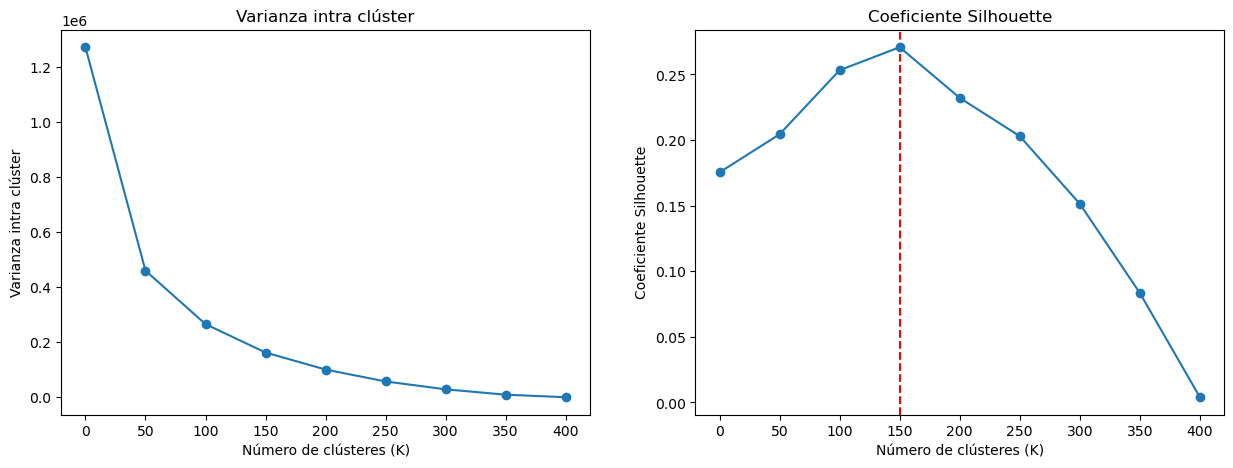

In [46]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

axs = ax.flatten()
mejor_silhouette = np.argmax(arr_silhouete)


axs[0].plot(arr_iteracion, arr_inertia, marker='o')
axs[0].set_xlabel('Número de clústeres (K)')
axs[0].set_ylabel('Varianza intra clúster')
axs[0].set_title("Varianza intra clúster")

axs[1].axvline(x=arr_iteracion[mejor_silhouette], color = 'r', linestyle = '--')
axs[1].plot(arr_iteracion, arr_silhouete , marker='o')
axs[1].set_xlabel('Número de clústeres (K)')
axs[1].set_ylabel('Coeficiente Silhouette')
axs[1].set_title("Coeficiente Silhouette")

plt.show()

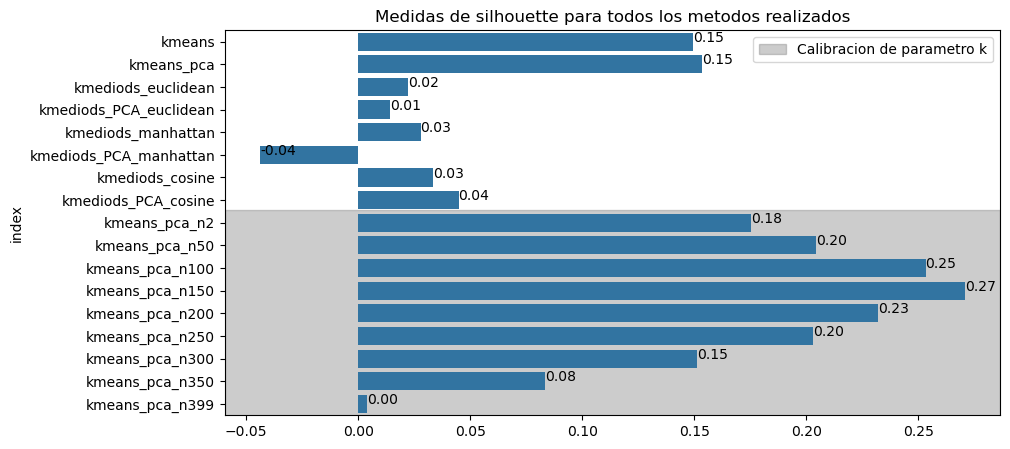

In [47]:
df_silhouette = pd.DataFrame.from_dict(dict_silhouette,orient="index").reset_index()
c_silhouette = df_silhouette["index"].str.contains("kmeans_n")

fig, ax = plt.subplots(figsize=(10,5))
ax.axhspan(8-0.55, df_silhouette.shape[0], color = "grey", alpha=0.4, label = "Calibracion de parametro k")
sns.barplot(data=df_silhouette[:], y="index", x=0)
ax.set_title("Medidas de silhouette para todos los metodos realizados")
ax.set_xlabel("")

for index, value in enumerate(df_silhouette.loc[:,0]):
    ax.text(value, index, f'{value:.2f}', color='black', ha="left")

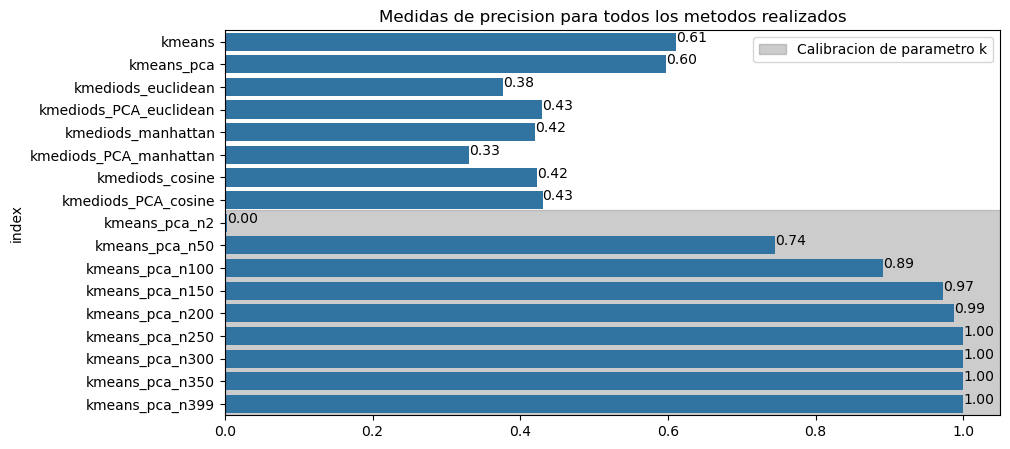

In [48]:
#pd.DataFrame.from_dict(dict_silhouette,orient="index").reset_index()
df_precision = pd.DataFrame.from_dict({k: v["precision"] for k, v in dict_class_report.items()},orient="index").reset_index()
c_silhouette = df_precision["index"].str.contains("kmeans_n")

fig, ax = plt.subplots(figsize=(10,5))
ax.axhspan(8-0.55, df_precision.shape[0], color = "grey", alpha=0.4, label = "Calibracion de parametro k")
sns.barplot(data=df_precision[:], y="index", x=0)
ax.set_title("Medidas de precision para todos los metodos realizados")
ax.set_xlabel("")

for index, value in enumerate(df_precision.loc[:,0]):
    ax.text(value, index, f'{value:.2f}', color='black', ha="left")

#### Resultados
* En este caso el criterio de codo en la varianza intracluster no permite obtener una conclusion ya que no hay un codo evidente.

* Con la metrica de silhouette el mejor resultado se obtiene en **X** esto quiere decir que con esta cantidad de clusters los puntos de un cluster son lo mas similares entre si mientras mantienen una diferencia "alta" con el resto.

* Al comparar el resultado con $k=XX$ vs las primeras iteraciones con $k = 40$, se ve una mejora evidente en la metrica **silhouette**. Esto se debe a que los clústers "adicionaes" identificados capturan distintas caracteristicas de las imagenes. A continuacion se ilutra esto:


In [50]:
# Crear un dataframe en donde se muestra que a que imagen corresponden los cluster encontrados por k means (homologacion)
gr_best_kmeans = df_images_scaled.groupby(['homolog_kmeans_pca_n150','predict_kmeans_pca_n150'])[[0]].count()
gr_best_kmeans.rename(columns={0:"n_imagenes_clasificadas"},inplace=True)
gr_best_kmeans["n_clusters"] = gr_best_kmeans.groupby(["homolog_kmeans_pca_n150"]).transform("count")
gr_best_kmeans = gr_best_kmeans.reset_index().sort_values(by=["n_clusters","homolog_kmeans_pca_n150"])

14


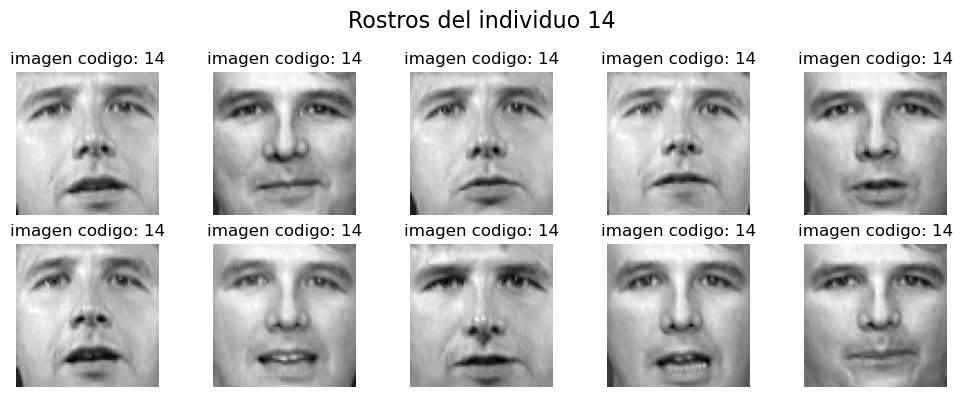

8


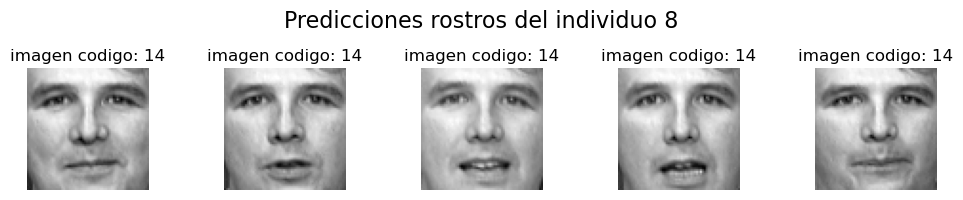

66


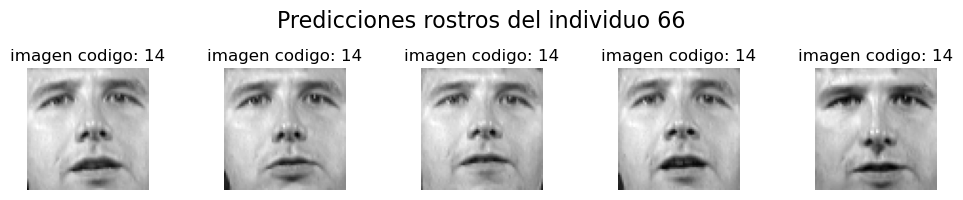

In [51]:
n = gr_best_kmeans.iloc[0,0]

print(n)
graficar_imagenes_individuo_original(n)

c = gr_best_kmeans["homolog_kmeans_pca_n150"] == n

for b in gr_best_kmeans[c]["predict_kmeans_pca_n150"].values:
    print(b)
    graficar_imagenes_individuo_predicho(b,"predict_kmeans_pca_n150")

El primer conjunto de imágenes corresponde a las 10 fotos del sujeto 14. Las imágenes siguientes pertenecen a los clústeres identificados que, tras la homologación de etiquetas, se asignaron como clústeres de rostros del mismo sujeto. Al analizar estas imágenes, se observa que las primeras son fotografías tomadas de frente, mientras que las siguientes presentan un ligero contrapicado.

# Conclusiones

* K-Means es un algoritmo que logra agrupar de forma eficiente grupos de datos, incluso datos con alta complejidad como lo son imagenes
* Nuevamente se evidencias las bondades de PCA que puede reducir la base de datos a menos componentes sin perder tanta informacion
* Utilizar PCA antes de dividir en clusters resulta favorable, probablemente por la caracteristica de PCA de volver cada componente ortogonal entre si, lo que permitiria al algoritmo de k medias identificar mas facilmente los grupos
* K-mediodes es una alternativa a K-means en ciertos casos donde la existencia de outliers hacer que K-means sea insuficiente en identificar agrupaciones
* Este ejercicio permitia validar los resultados de un cluster al ser un ejercicio supervisado ya que contaba con las etiquetas de los rostros. Esto nos permitio evidenciar que no siempre la cantidad optima de clusters obedece a la realidad de los datos, ya que en este ejercicio solo habia 40 rostros pero el mejor $k$ resulto ser mas alto. Lo que nos decia que los cluster capturaban distintas caracteristicas de un mismo rostro (diferentes angulos de foto, diferentes expresiones faciales, etc.)
* No siempre es evidente la eleccion de un $k$ con el metodo del codo, por lo que la metrica de silhouette nos ayuda a realizar una mejor elección.
* Los resultados de la agrupacion son asignaciones de datos a un cluster, por lo que la interpretacion de que significan estos, o que tipo de caracteristica tienen los grupos identificados, recae en en analista. que se debe de valer de los centroides para entender los resultados.
